In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("rfm-lr.csv")
df.head()

,Date,Timestamp,Account No,Balance,Amount,Third Party Name
0,01/01/2023,00:00,624500124,2564.01,7.99,Large Retailers
1,01/01/2023,00:00,768271776,2133.06,7.99,Large Retailers
2,01/01/2023,00:00,215404070,1922.03,7.99,Large Retailers
3,01/01/2023,00:00,564744955,814.02,7.99,Large Retailers
4,01/01/2023,00:00,779816907,567.01,7.99,Large Retailers


In [2]:
import seaborn as sns
sns.set_palette("husl")
sns.set(rc={'image.cmap': 'coolwarm'})
%matplotlib inline

In [3]:
import datetime as dt
df['InvoiceDate'] = pd.to_datetime(df['Date'], dayfirst=True).dt.date

In [4]:
df = df[pd.notnull(df['Account No'])]
df = df[(df['Amount']>0)]


In [5]:
cols_of_interest = ['Account No', 'InvoiceDate', 'Amount']
df = df[cols_of_interest]

In [6]:
print(df.head())
print(df['Account No'].nunique())

   Account No InvoiceDate  Amount
0   624500124  2023-01-01    7.99
1   768271776  2023-01-01    7.99
2   215404070  2023-01-01    7.99
3   564744955  2023-01-01    7.99
4   779816907  2023-01-01    7.99
870


In [9]:
from lifetimes.plotting import *
from lifetimes.utils import *
# from lifetimes.estimation import *

data = summary_data_from_transaction_data(df, 'Account No', 'InvoiceDate', monetary_value_col='Amount', observation_period_end='2023-12-6')
data.head()

,frequency,recency,T,monetary_value
Account No,,,,
104832000,0.0,0.0,333.0,0.000000
105375973,21.0,333.0,339.0,127.208571
106601471,23.0,279.0,289.0,28.356957
108481285,97.0,339.0,339.0,22.734742
108563213,74.0,338.0,339.0,25.624189


count    870.000000
mean      23.650575
std       25.142168
min        0.000000
25%        5.000000
50%       14.000000
75%       33.000000
max      122.000000
Name: frequency, dtype: float64
0.0896551724137931


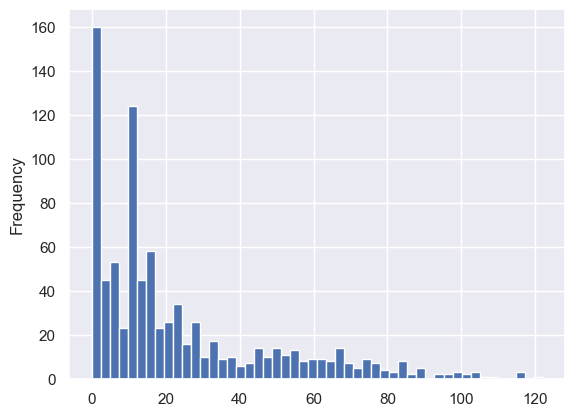

In [10]:
data['frequency'].plot(kind='hist', bins=50)
print(data['frequency'].describe())
print(sum(data['frequency'] == 0)/float(len(data)))

In [11]:

from lifetimes import BetaGeoFitter

# similar API to scikit-learn and lifelines.
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 870 subjects, a: 0.03, alpha: 10.81, b: 0.72, r: 0.89>


<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

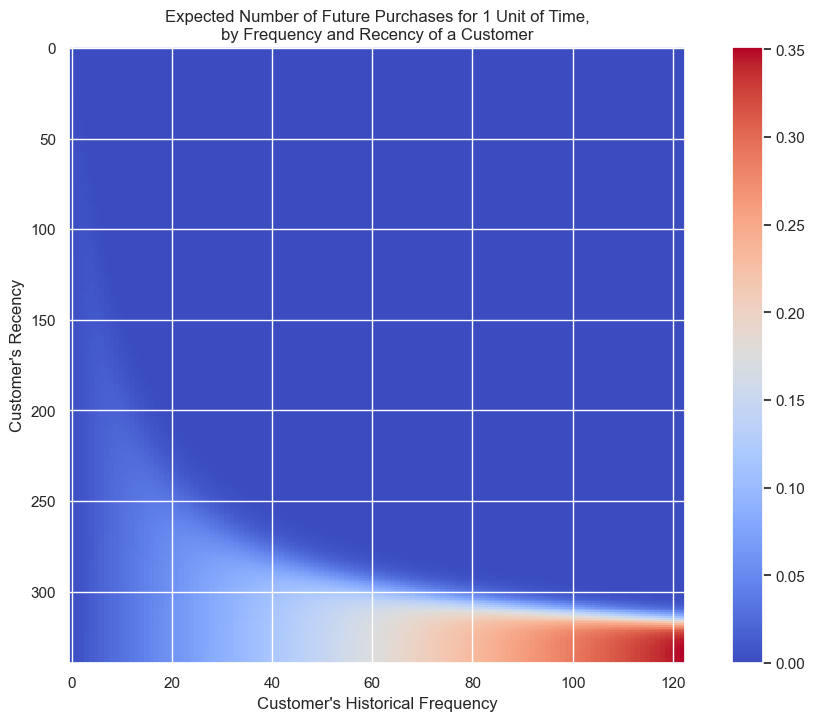

In [12]:
from lifetimes.plotting import plot_frequency_recency_matrix
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf)

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

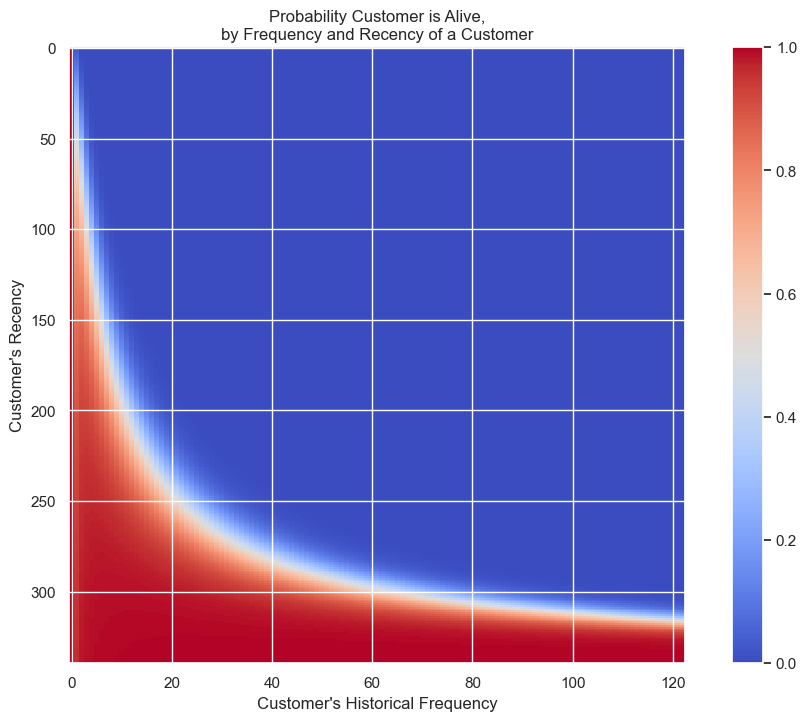

In [13]:
from lifetimes.plotting import plot_probability_alive_matrix
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)


In [15]:

t = 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
Account No,,,,,
749378808,98.0,291.0,292.0,22.739796,0.326423
264550521,117.0,337.0,339.0,26.431368,0.336828
806358207,117.0,339.0,339.0,33.360085,0.336915
987656636,117.0,334.0,334.0,22.106667,0.341800
355733816,122.0,334.0,336.0,21.738361,0.354152


<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

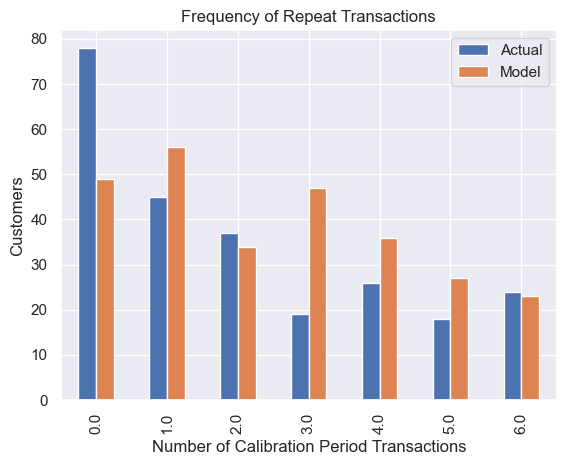

In [16]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

In [17]:
from lifetimes.utils import calibration_and_holdout_data

summary_cal_holdout = calibration_and_holdout_data(df, 'Account No', 'InvoiceDate',
                                        calibration_period_end='2023-06-08',
                                        observation_period_end='2023-12-9' )   
print(summary_cal_holdout.head())

            frequency_cal  recency_cal  T_cal  frequency_holdout  \
Account No                                                         
104832000             0.0          0.0  152.0                0.0   
105375973            13.0        150.0  158.0                8.0   
106601471             6.0        107.0  108.0               17.0   
108481285            30.0        158.0  158.0               67.0   
108563213            18.0        157.0  158.0               56.0   

            duration_holdout  
Account No                    
104832000              184.0  
105375973              184.0  
106601471              184.0  
108481285              184.0  
108563213              184.0  


<Axes: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

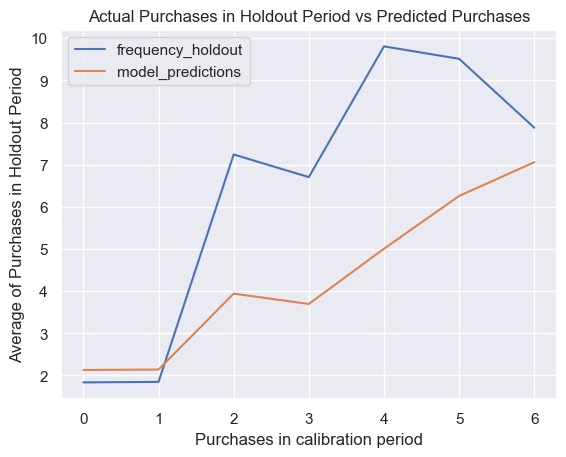

In [18]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

In [20]:
t = 10 #predict purchases in 10 periods
individual = data.loc[105375973]
# The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_to_time`
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

0.6189248363584486

In [22]:
data.loc[105375973]

frequency               21.000000
recency                333.000000
T                      339.000000
monetary_value         127.208571
predicted_purchases      0.062445
Name: 105375973, dtype: float64

In [25]:

returning_customers_summary = data[data['frequency']>0]

print(returning_customers_summary.head())
print(len(returning_customers_summary))

            frequency  recency      T  monetary_value  predicted_purchases
Account No                                                                
105375973        21.0    333.0  339.0      127.208571             0.062445
106601471        23.0    279.0  289.0       28.356957             0.079444
108481285        97.0    339.0  339.0       22.734742             0.279743
108563213        74.0    338.0  339.0       25.624189             0.213974
108812033         5.0    272.0  339.0       21.768000             0.016465
792


In [26]:
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,-0.087359
frequency,-0.087359,1.000000


In [27]:

from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 792 subjects, p: 1.03, q: 3.90, v: 78.39>


In [28]:
print(ggf.conditional_expected_average_profit(
        data['frequency'],
        data['monetary_value']
    ).head(10))

Account No
104832000     27.924371
105375973    115.501573
106601471     28.309902
108481285     22.880707
108563213     25.708258
108812033     23.981620
108931112     18.380798
111137699     27.924371
113747882     29.637216
116169597     45.056644
dtype: float64


In [29]:

bgf.fit(data['frequency'], data['recency'], data['T'])

print(ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    data['frequency'],
    data['recency'],
    data['T'],
    data['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
).head(10))

Account No
104832000            NaN
105375973    2405.004114
106601471     748.793964
108481285    2135.158561
108563213    1834.932686
108812033     131.481160
108931112     470.646255
111137699            NaN
113747882    2339.644042
116169597     852.056281
Name: clv, dtype: float64
